# Segmentação de Bombons em Imagens Digitais

**Autores:** Matheus de Souza Matos e Flavio Henrique de Jesus Cruz  
**Disciplina:** Processamento de Imagens  
**Instituição:** Universidade Federal de Sergipe

---

## Introdução

Este trabalho tem como objetivo segmentar automaticamente bombons presentes em imagens digitais, separando-os do fundo e contando quantos existem na cena. A abordagem utiliza exclusivamente técnicas clássicas de processamento de imagens, sem nenhum método de aprendizado de máquina.

O pipeline consiste nas seguintes etapas:

1. Conversão para escala de cinza
2. Análise do histograma
3. Binarização pelo método de Otsu
4. Morfologia matemática (abertura e fechamento)
5. Rotulação de componentes conexos e contagem

**Dataset utilizado:** Valentines Chocolates — Roboflow  
https://universe.roboflow.com/chocolates/valentines-chocolates/

## 1. Importação de Bibliotecas

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.morphology import disk, binary_opening, binary_closing
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Carregamento da Imagem

Dimensões : (150, 200, 3)
Tipo      : uint8
Min / Max : 0 / 255


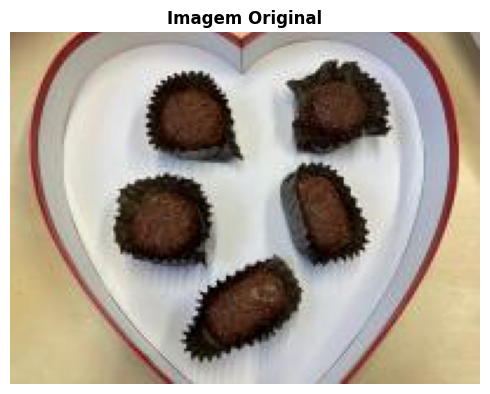

In [6]:
imagem_original = io.imread('/content/thumb.jpg')

print(f"Dimensões : {imagem_original.shape}")
print(f"Tipo      : {imagem_original.dtype}")
print(f"Min / Max : {imagem_original.min()} / {imagem_original.max()}")

plt.figure(figsize=(5, 5))
plt.imshow(imagem_original)
plt.title('Imagem Original', fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## 3. Conversão para Escala de Cinza

Convertemos a imagem RGB para escala de cinza usando a ponderação padrão que leva em conta a sensibilidade do olho humano a cada canal de cor:

$$\text{Gray} = 0{,}2989 \cdot R + 0{,}5870 \cdot G + 0{,}1140 \cdot B$$

Essa etapa reduz as três bandas de cor a uma única camada de intensidade, o que é suficiente para a segmentação baseada em contraste.

Dimensão após conversão: (150, 200)
Intensidade média      : 153.0


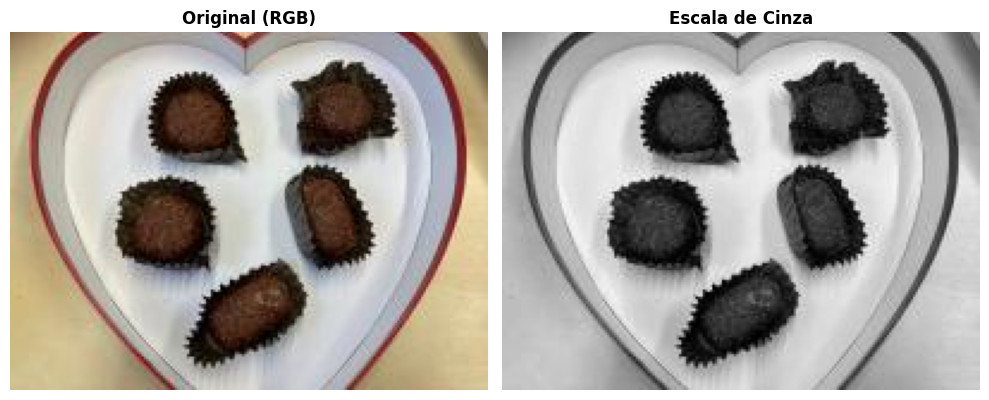

In [7]:
imagem_gray = color.rgb2gray(imagem_original)
imagem_gray = (imagem_gray * 255).astype(np.uint8)

print(f"Dimensão após conversão: {imagem_gray.shape}")
print(f"Intensidade média      : {imagem_gray.mean():.1f}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(imagem_original)
axes[0].set_title('Original (RGB)', fontweight='bold')
axes[0].axis('off')
axes[1].imshow(imagem_gray, cmap='gray')
axes[1].set_title('Escala de Cinza', fontweight='bold')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## 4. Análise do Histograma

O histograma mostra a frequência de cada nível de intensidade na imagem. Observar o histograma antes de binarizar é importante para entender a distribuição de intensidades e verificar se existe uma separação clara entre o fundo (claro) e os bombons (escuros).

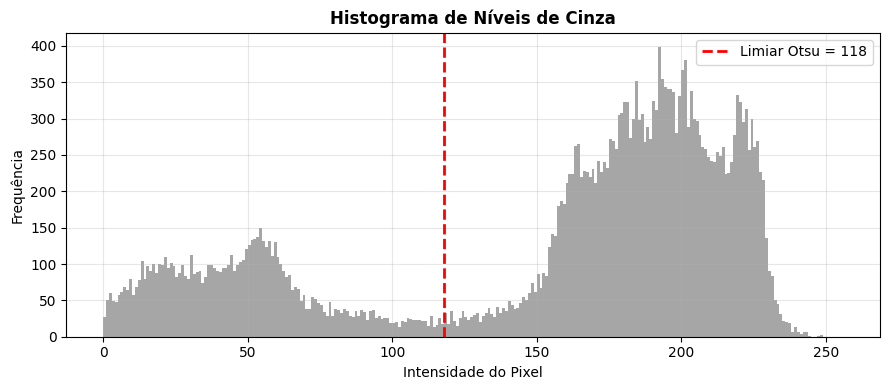

Média   : 153.0
Desvio  : 67.8
Limiar (Otsu): 118


In [8]:
limiar = threshold_otsu(imagem_gray)

plt.figure(figsize=(9, 4))
plt.hist(imagem_gray.ravel(), bins=256, range=(0, 256), color='gray', alpha=0.7)
plt.axvline(limiar, color='red', linestyle='--', linewidth=2, label=f'Limiar Otsu = {limiar}')
plt.title('Histograma de Níveis de Cinza', fontweight='bold')
plt.xlabel('Intensidade do Pixel')
plt.ylabel('Frequência')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Média   : {imagem_gray.mean():.1f}")
print(f"Desvio  : {imagem_gray.std():.1f}")
print(f"Limiar (Otsu): {limiar}")

## 5. Binarização pelo Método de Otsu

A binarização converte a imagem em escala de cinza em uma imagem binária (apenas 0 e 1). O **método de Otsu** determina automaticamente o limiar ótimo ao maximizar a variância entre as duas classes — fundo e objeto.

Como os bombons são **mais escuros** que o fundo branco da caixinha, usamos a condição `pixel < limiar` para marcá-los como objetos (branco na máscara).

Limiar de Otsu aplicado: 118
Pixels de objeto (escuros): 7765
Pixels de fundo  (claros) : 22235


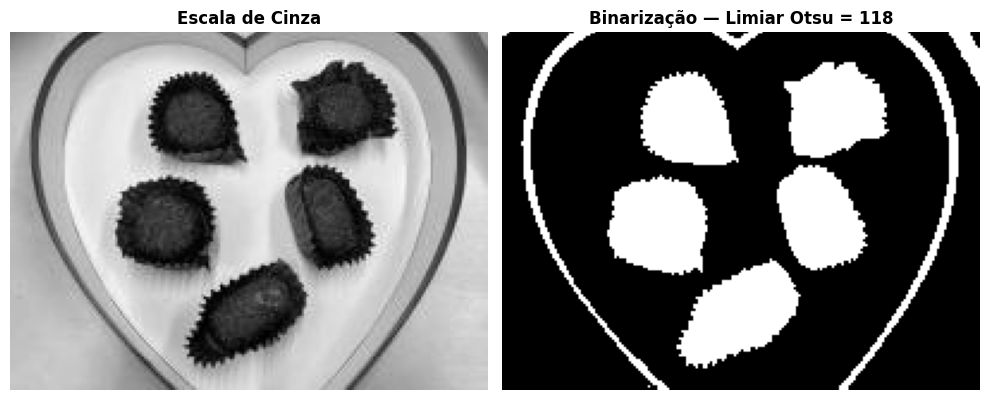

In [9]:
imagem_binaria = imagem_gray < limiar

print(f"Limiar de Otsu aplicado: {limiar}")
print(f"Pixels de objeto (escuros): {imagem_binaria.sum()}")
print(f"Pixels de fundo  (claros) : {(~imagem_binaria).sum()}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(imagem_gray, cmap='gray')
axes[0].set_title('Escala de Cinza', fontweight='bold')
axes[0].axis('off')
axes[1].imshow(imagem_binaria, cmap='gray')
axes[1].set_title(f'Binarização — Limiar Otsu = {limiar}', fontweight='bold')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## 6. Morfologia Matemática

As operações morfológicas trabalham sobre a forma dos objetos na imagem binária, usando um **elemento estruturante** como referência.

Utilizamos um **elemento estruturante circular (disco)**, que respeita a forma arredondada dos bombons.

### Abertura (erosão → dilatação)
Remove pequenos ruídos e fragmentos isolados que aparecem após a binarização, sem comprometer muito a forma dos objetos maiores.

### Fechamento (dilatação → erosão)
Preenche pequenos buracos internos que a binarização deixou nos bombons, consolidando cada objeto em uma região contínua.

In [10]:
# Elemento estruturante: disco de raio 3
raio = 3
ee = disk(raio)

print(f"Elemento estruturante — disco de raio {raio}:")
print(ee.astype(int))

Elemento estruturante — disco de raio 3:
[[0 0 0 1 0 0 0]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [1 1 1 1 1 1 1]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [0 0 0 1 0 0 0]]


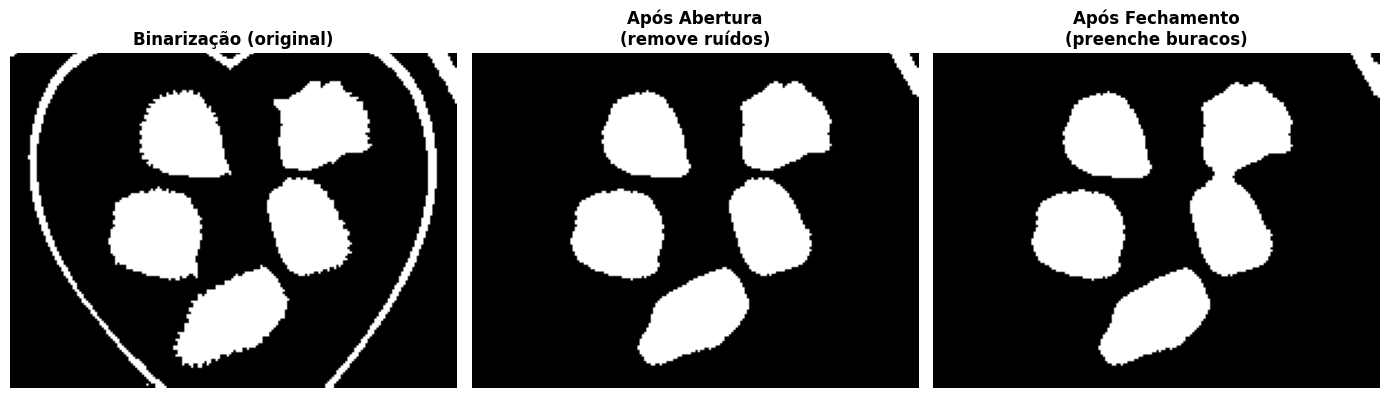

Pixels antes da abertura : 7765
Pixels após abertura     : 6343
Pixels após fechamento   : 6385


In [11]:
# Abertura
imagem_abertura = binary_opening(imagem_binaria, ee)

# Fechamento
imagem_fechamento = binary_closing(imagem_abertura, ee)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].imshow(imagem_binaria, cmap='gray')
axes[0].set_title('Binarização (original)', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(imagem_abertura, cmap='gray')
axes[1].set_title('Após Abertura\n(remove ruídos)', fontweight='bold')
axes[1].axis('off')

axes[2].imshow(imagem_fechamento, cmap='gray')
axes[2].set_title('Após Fechamento\n(preenche buracos)', fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Pixels antes da abertura : {imagem_binaria.sum()}")
print(f"Pixels após abertura     : {imagem_abertura.sum()}")
print(f"Pixels após fechamento   : {imagem_fechamento.sum()}")

## 7. Rotulação e Contagem de Bombons

Com a máscara binária refinada, rotulamos cada **componente conexo** (grupo de pixels brancos conectados entre si). Cada componente recebe um número único, permitindo identificar e contar os bombons individualmente.

Um filtro por **área mínima** é aplicado para descartar eventuais fragmentos residuais muito pequenos que não correspondem a bombons reais.

Regiões detectadas no total : 5
Bombons (área >= 200 px)  : 4

Bombom 1: área=2429 px  centroide=(55, 136)  perímetro=268.8 px
Bombom 2: área=1152 px  centroide=(38, 77)  perímetro=134.0 px
Bombom 3: área=1336 px  centroide=(81, 65)  perímetro=145.0 px
Bombom 4: área=1334 px  centroide=(118, 99)  perímetro=151.9 px


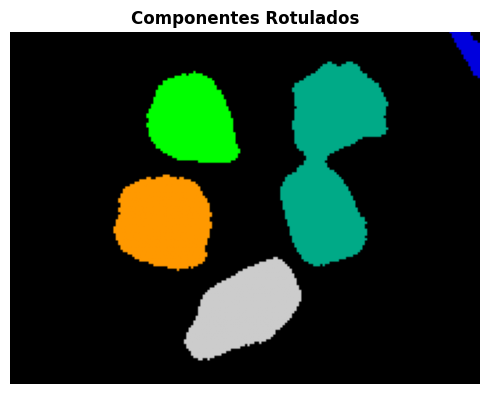

In [12]:
imagem_rotulada = label(imagem_fechamento)
regioes = regionprops(imagem_rotulada)

area_minima = 200  # pixels
bombons = [r for r in regioes if r.area >= area_minima]

print(f"Regiões detectadas no total : {len(regioes)}")
print(f"Bombons (área >= {area_minima} px)  : {len(bombons)}")
print()
for i, b in enumerate(bombons, 1):
    print(f"Bombom {i}: área={int(b.area)} px  "
          f"centroide=({b.centroid[0]:.0f}, {b.centroid[1]:.0f})  "
          f"perímetro={b.perimeter:.1f} px")

plt.figure(figsize=(5, 4))
plt.imshow(imagem_rotulada, cmap='nipy_spectral')
plt.title('Componentes Rotulados', fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## 8. Resultado Final

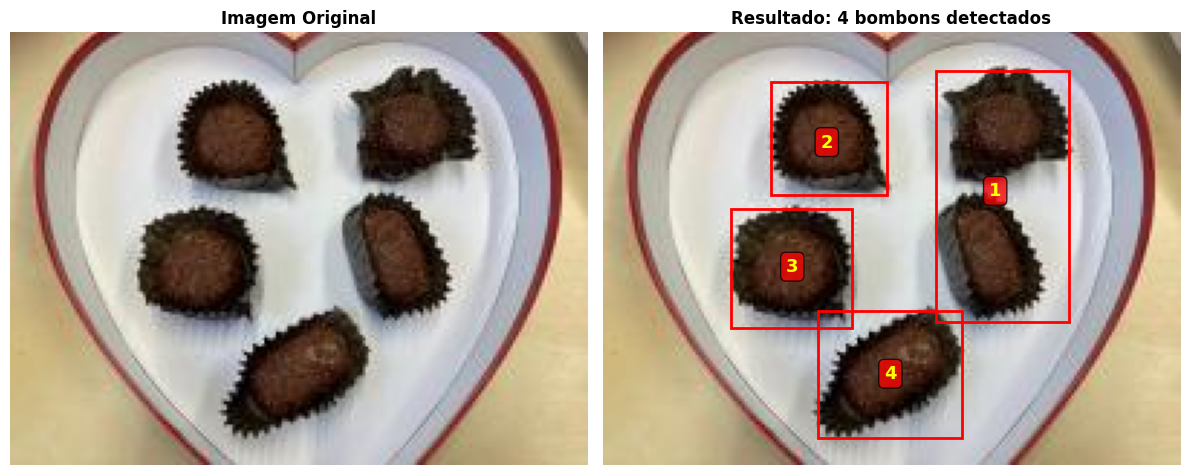

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(imagem_original)
axes[0].set_title('Imagem Original', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(imagem_original)
for i, b in enumerate(bombons, 1):
    minr, minc, maxr, maxc = b.bbox
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                          fill=False, edgecolor='red', linewidth=2)
    axes[1].add_patch(rect)
    cy, cx = b.centroid
    axes[1].text(cx, cy, str(i), color='yellow', fontsize=13,
                 fontweight='bold', ha='center', va='center',
                 bbox=dict(boxstyle='round', facecolor='red', alpha=0.75))

axes[1].set_title(f'Resultado: {len(bombons)} bombons detectados', fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 9. Análise dos Bombons Detectados

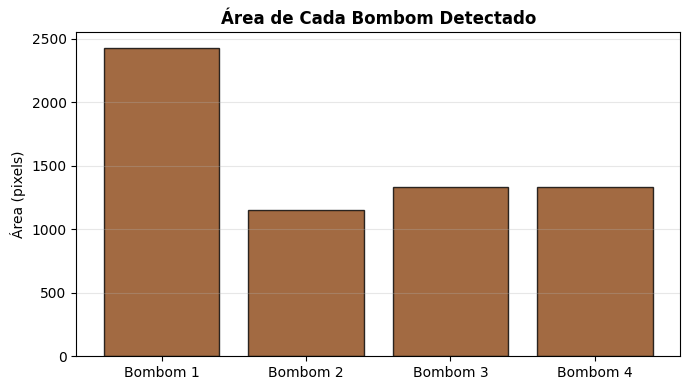

Área média  : 1562.8 px
Área mínima : 1152 px
Área máxima : 2429 px


In [14]:
areas = [int(b.area) for b in bombons]

plt.figure(figsize=(7, 4))
plt.bar([f'Bombom {i}' for i in range(1, len(areas)+1)],
        areas, color='saddlebrown', alpha=0.8, edgecolor='black')
plt.ylabel('Área (pixels)')
plt.title('Área de Cada Bombom Detectado', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Área média  : {np.mean(areas):.1f} px")
print(f"Área mínima : {np.min(areas)} px")
print(f"Área máxima : {np.max(areas)} px")

## 10. Conclusões

O pipeline desenvolvido segmenta bombons em imagens digitais por meio de técnicas clássicas de processamento de imagens, sem uso de aprendizado de máquina.

**Resultados obtidos:**
- A binarização com Otsu separou com sucesso os bombons (escuros) do fundo (claro)
- A abertura morfológica eliminou ruídos da máscara binária
- O fechamento morfológico preencheu buracos internos nos objetos
- A rotulação identificou individualmente cada região de bombom

**Limitações observadas:**
- A imagem de teste é de baixa resolução (150×200 px), o que reduz a qualidade da segmentação
- Dois bombons posicionados muito próximos ficaram fundidos em uma única região na máscara binária, sendo contados como um único objeto
- O método depende de bom contraste entre o bombom e o fundo; iluminações irregulares podem comprometer a binarização

**Possíveis melhorias:**
- Usar imagens em resolução maior do dataset original
- Experimentar equalização de histograma como pré-processamento para imagens de baixo contraste
- Ajustar o raio do elemento estruturante de acordo com o tamanho dos bombons na imagem

---
**Autores:** Matheus de Souza Matos e Flavio Henrique de Jesus Cruz  
**Disciplina:** Processamento de Imagens — UFS, Fevereiro de 2026